https://archive.ics.uci.edu/ml/datasets/Parkinson+Speech+Dataset+with++Multiple+Types+of+Sound+Recordings

In [466]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns


In [433]:
# setting up seed
# Set seed value
#import os
#os.environ['PYTHONHASHSEED']=str(42)
#import random
def reset_seed():
    seed_value = 42
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value  
    tf.random.set_seed(seed_value)



In [434]:
# Import data and preprocessing
data = pd.read_csv('park_train_data.txt', names = ['Subject id', 'Jitter local', 'Jitter local absolute', 'Jitter rap', 'Jitter ppq5', 'Jitter ddp', 'Shimmer local', 'Shimmer local dB', 'Shimmer apq3', 'Shimmer apq5', 'Shimmer apq11', 'Shimmer dda', 'AC', 'NTH', 'HTN', 'Median pitch', 'Mean pitch', 'Standard deviation', 'Minimum pitch', 'Maximum pitch', 'Number of pulses', 'Number of periods', 'Mean period', 'Standard deviation of period', 'Fraction of locally unvoiced frames', 'Number of voice breaks', 'Degree of voice breaks','UPDRS', 'class information'])

data = data.drop(['Subject id', 'UPDRS'], axis = 1) #  col 1 - person id and col 27 - UPDRS column
# Select appropriate columns for X and y
y = data.iloc[:,-1]
X_raw = data.iloc[:,:-1]
# Scale all feature columns between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X_raw)

In [435]:
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.4, random_state = 5)

In [436]:
loss = []
accuracy = []
recall = []
precision = []
auc = []

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.4, random_state = 42)
for i in range(1,11):
    #reset_seed()

    model = keras.models.Sequential([
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(15, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
    ])

    #sgd = keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.99)
    adam = keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy","Recall","Precision", "AUC"])

    history = model.fit(X_train, y_train.values, epochs = 300, validation_split = 0.4, verbose = 0)
    result = model.evaluate(X_test,y_test.values, verbose = 0)
    loss.append(result[0])
    accuracy.append(result[1])
    recall.append(result[2])
    precision.append(result[3])
    auc.append(result[4])


In [437]:
#print("MEANS\nAccuracy =",accuracy.mean)
accuracym = round(np.asarray(accuracy).mean(), 3)
lossm = round(np.asarray(loss).mean(), 3)
recallm = round(np.asarray(recall).mean(), 3)
precisionm = round(np.asarray(precision).mean(), 3)
aucm = round(np.asarray(auc).mean(), 3)

print('MEAN VALUES\nAccuracy = ', accuracym,'\nLoss = ', lossm, '\nRecall = ',recallm, '\nPrecision = ', precisionm, '\nAUC =', aucm)

MEAN VALUES
Accuracy =  0.651 
Loss =  0.62 
Recall =  0.718 
Precision =  0.649 
AUC = 0.705


In [438]:
# 95% confidence intervals
import scipy.stats as st
ci_accuracy = st.t.interval(0.95, len(accuracy)-1, loc=np.mean(accuracy), scale=st.sem(accuracy))
ci_loss = st.t.interval(0.95, len(loss)-1, loc=np.mean(loss), scale=st.sem(loss))
ci_recall = st.t.interval(0.95, len(recall)-1, loc=np.mean(recall), scale=st.sem(recall))
ci_precision = st.t.interval(0.95, len(precision)-1, loc=np.mean(precision), scale=st.sem(precision))
ci_auc = st.t.interval(0.95, len(auc)-1, loc=np.mean(auc), scale=st.sem(auc))

ci_accuracy = tuple(map(lambda x: isinstance(x, float) and round(x, 3) or x, ci_accuracy))
ci_loss = tuple(map(lambda x: isinstance(x, float) and round(x, 3) or x, ci_loss))
ci_recall = tuple(map(lambda x: isinstance(x, float) and round(x, 3) or x, ci_recall))
ci_precision = tuple(map(lambda x: isinstance(x, float) and round(x, 3) or x, ci_precision))
ci_auc = tuple(map(lambda x: isinstance(x, float) and round(x, 3) or x, ci_auc))

print('95% Confidence Intervals\nAccuracy = ',ci_accuracy,'\nLoss = ', ci_loss, '\nRecall = ',ci_recall, '\nPrecision = ', ci_precision, '\nAUC =', ci_auc)

95% Confidence Intervals
Accuracy =  (0.645, 0.658) 
Loss =  (0.614, 0.626) 
Recall =  (0.697, 0.738) 
Precision =  (0.64, 0.657) 
AUC = (0.699, 0.71)


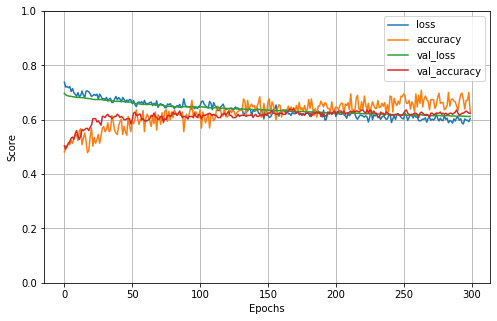

In [439]:
all_results = history.history
compact_results = dict((k, all_results[k]) for k in ('loss', 'accuracy', 'val_loss', 'val_accuracy'))
pd.DataFrame(compact_results).plot(figsize=(8, 5))
plt.xlabel(xlabel ="Epochs")
plt.ylabel(ylabel ="Score")
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [446]:

predict = model.predict_classes(X_test)
matrix = confusion_matrix(y_test, predict)

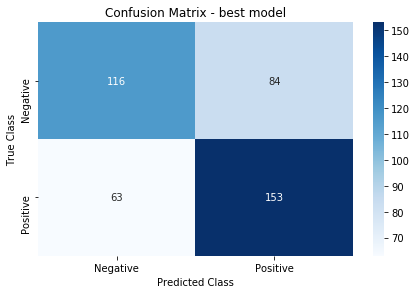

In [451]:
class_names = ['Negative', 'Positive']
dataframe_Confusion =  pd.DataFrame(matrix, index=class_names, columns=class_names) 

sns.heatmap(dataframe_Confusion, annot=True,  cmap="Blues", fmt=".0f")
plt.title("Confusion Matrix - best model")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.savefig('./confusion_matrix.png')
plt.show()
plt.close()

In [456]:
report = classification_report(y_test, predict, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
df_classification_report

,precision,recall,f1-score,support
1,0.645570,0.708333,0.675497,216.000000
accuracy,0.646635,0.646635,0.646635,0.646635
weighted avg,0.646760,0.646635,0.645035,416.000000
macro avg,0.646807,0.644167,0.643817,416.000000
0,0.648045,0.580000,0.612137,200.000000


Text(0, 0.5, 'True Postitive Rate (Sensitivity)')

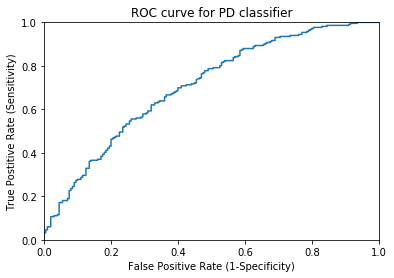

In [465]:
# ROC and AUC

predict_prob = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predict_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.0])
plt.title("ROC curve for PD classifier")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Postitive Rate (Sensitivity)")

In [467]:
roc_auc_score(y_test, predict_prob)

0.7054513888888888